## Mixture Density Networks

The core idea is to have a Neural Net that predicts an entire (and possibly complex)
distribution. In this example we're predicting a mixture of gaussians distributions via
its sufficient statistics (the means and diagonal covariances), which are on the last
layer of the neural network. This means that the network knows what it doesn't know:
it will predict diffuse distributions in situations where the target variable is very
noisy, and it will predict a much more peaky distribution in nearly deterministic parts.

See [Bishop 1994](http://eprints.aston.ac.uk/373/1/NCRG_94_004.pdf) for reference.

In [1]:
import h5py
import scipy
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

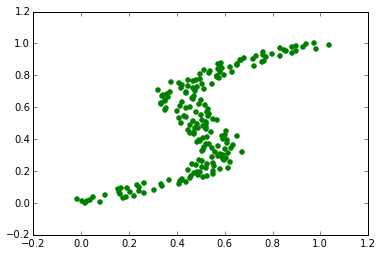

In [3]:
# generate some 1D regression data (reproducing Bishop book data, page 273). 
# Note that the P(y|x) is not a nice distribution. E.g. it has three modes for x ~= 0.5
N = 200
X = np.linspace(0,1,N)
Y = X + 0.3 * np.sin(2*3.1415926*X) + np.random.uniform(-0.1, 0.1, N)
X,Y = Y,X
plt.scatter(X,Y,color='g')

In [4]:
# model intialization
input_size = 1
hidden_size = 30
K = 3 # number of mixture components
m = {}
m['Wxh'] = np.random.randn(hidden_size, input_size) * 0.1 # input to hidden
m['Whu'] = np.random.randn(K, hidden_size) * 0.1 # hidden to means
m['Whs'] = np.random.randn(K, hidden_size) * 0.1 # hidden to log standard deviations
m['Whp'] = np.random.randn(K, hidden_size) * 0.1 # hidden to mixing coefficients (cluster priors)
m['bxh'] = np.random.randn(hidden_size, 1) * 0.01
m['bhu'] = np.random.randn(K, 1) * 0.01
m['bhs'] = np.random.randn(K, 1) * 0.01
m['bhp'] = np.random.randn(K, 1) * 0.01

In [5]:
def softmax(x):
    # softmaxes the columns of x
    #z = x - np.max(x, axis=0, keepdims=True) # for safety
    e = np.exp(x)
    en = e / np.sum(e, axis=0, keepdims=True)
    return en

def mdn_loss(x, y, m):
    # data in X are columns
    
    # forward pass
    h = np.tanh(np.dot(m['Wxh'], x) + m['bxh'])
    # predict mean
    mu = np.dot(m['Whu'], h) + m['bhu']
    # predict log variance
    logsig = np.dot(m['Whs'], h) + m['bhs']
    sig = np.exp(logsig)
    # predict mixture priors
    piu = np.dot(m['Whp'], h) + m['bhp'] # unnormalized pi
    pi = softmax(piu)
    # compute the loss: mean negative data log likelihood
    k,n = mu.shape # number of mixture components
    ps = np.exp(-((y - mu)**2)/(2*sig**2))/(sig*np.sqrt(2*math.pi))
    pin = ps * pi
    lp = -np.log(np.sum(pin, axis=0, keepdims=True))
    loss = np.sum(lp)/n
    
    # compute the gradients on nn outputs
    grad = {}
    gammas = pin / np.sum(pin, axis=0, keepdims = True)
    dmu = gammas * ((mu - y)/sig**2) /n
    dlogsig = gammas * (1.0 - (y-mu)**2/(sig**2)) /n
    dpiu = (pi - gammas) /n
    # backprop to decoder matrices
    grad['bhu'] = np.sum(dmu, axis=1, keepdims=True)
    grad['bhs'] = np.sum(dlogsig, axis=1, keepdims=True)
    grad['bhp'] = np.sum(dpiu, axis=1, keepdims=True)
    grad['Whu'] = np.dot(dmu, h.T)
    grad['Whs'] = np.dot(dlogsig, h.T)
    grad['Whp'] = np.dot(dpiu, h.T)
    # backprop to h
    dh = np.dot(m['Whu'].T, dmu) + np.dot(m['Whs'].T, dlogsig) + np.dot(m['Whp'].T, dpiu)
    # backprop tanh
    dh = (1.0-h**2)*dh
    # backprop input to hidden
    grad['bxh'] = np.sum(dh, axis=1, keepdims=True)
    grad['Wxh'] = np.dot(dh, x.T)
    
    # misc stats
    stats = {}
    stats['lp'] = lp
    return loss, grad, stats
    

In [7]:
# utility function for creating contour plot of the predictions
def drawContour(m):
    n = 50
    xx = np.linspace(0,1,n)
    yy = np.linspace(0,1,n)
    xm, ym = np.meshgrid(xx, yy)
    _, _, stats = mdn_loss(xm.reshape(1, xm.size), ym.reshape(1, ym.size), m)
    logps = stats['lp']
    plt.figure(figsize=(10,10))
    plt.scatter(X,Y,color='g')
    lp = stats['lp']
    plt.contour(xm, ym, np.reshape(logps, (n, n)), levels=np.linspace(lp.min(), lp.max(), 20))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('3-component Gaussian Mixture Model for P(y|x)')
#drawContour(m)

In [8]:
nb = N # full batch
xbatch = np.reshape(X[:nb], (1,nb))
ybatch = np.reshape(Y[:nb], (1,nb))

In [9]:
# optimize
lr = 1e-2
mem = {}
for k in m.keys(): mem[k] = np.zeros_like(m[k]) # init adagrad
for k in range(20000):
    loss, grad, stats = mdn_loss(xbatch, ybatch, m)
    if k % 1000 == 0:
        print '%d: %f' % (k, loss)
    for k,v in grad.iteritems():
        mem[k] += grad[k]**2
        m[k] += -lr * grad[k] / np.sqrt(mem[k] + 1e-8)
        

0: 1.101843
1000: -0.656809
2000: -0.835534
3000: -0.886227
4000: -0.913057
5000: -0.929837
6000: -0.941867
7000: -0.951733
8000: -0.960423
9000: -0.967882
10000: -0.973781
11000: -0.978156
12000: -0.981655
13000: -0.984493
14000: -0.986977
15000: -0.989211
16000: -0.991234
17000: -0.993064
18000: -0.994716
19000: -0.996209


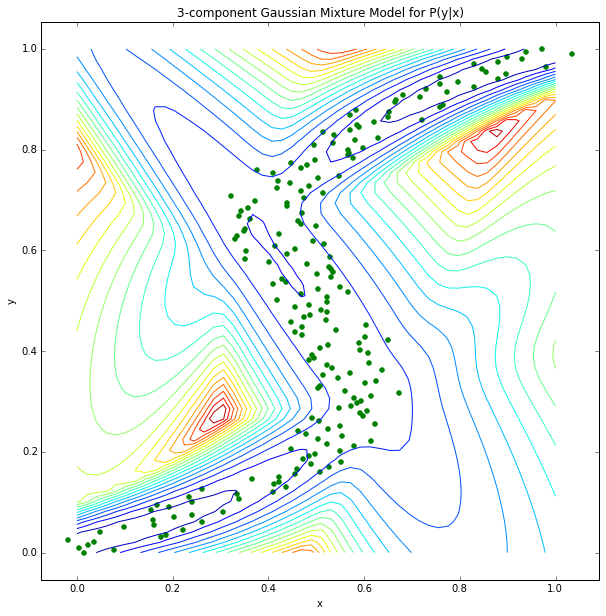

In [10]:
drawContour(m)

In [11]:
# Rung radient check

def wrapCost(batch, model):
    loss, grad, stats = mdn_loss(batch[0], batch[1], model)
    cg = {}
    cg['grad'] = grad
    cg['cost'] = {}
    cg['cost']['total_cost'] = loss
    return cg

def gradCheck(batch, model, cost_function, **kwargs):
    num_checks = kwargs.get('num_checks', 10)
    delta = kwargs.get('delta', 1e-5)
    rel_error_thr_warning = kwargs.get('rel_error_thr_warning', 1e-2)
    rel_error_thr_error = kwargs.get('rel_error_thr_error', 1)

    cg = cost_function(batch, model)

    print 'running gradient check...'
    for p in model.keys():
      print 'checking gradient on parameter %s of shape %s...' % (p, `model[p].shape`)
      mat = model[p]

      s0 = cg['grad'][p].shape
      s1 = mat.shape
      assert s0 == s1, 'Error dims dont match on %s: grad: %s vs. param: %s.' % (p, `s0`, `s1`)

      for i in xrange(num_checks):
        #ri = randi(mat.size)
        ri = np.random.randint(0, mat.size)

        # evluate cost at [x + delta] and [x - delta]
        old_val = mat.flat[ri]
        mat.flat[ri] = old_val + delta
        cg0 = cost_function(batch, model)
        mat.flat[ri] = old_val - delta
        cg1 = cost_function(batch, model)
        mat.flat[ri] = old_val # reset old value for this parameter

        # fetch both numerical and analytic gradient
        grad_analytic = cg['grad'][p].flat[ri]
        grad_numerical = (cg0['cost']['total_cost'] - cg1['cost']['total_cost']) / ( 2 * delta )

        # compare them
        if grad_numerical == 0 and grad_analytic == 0:
          rel_error = 0 # both are zero, OK.
          status = 'OK'
        elif abs(grad_numerical) < 1e-7 and abs(grad_analytic) < 1e-7:
          rel_error = 0 # not enough precision to check this
          status = 'VAL SMALL WARNING'
        else:
          rel_error = abs(grad_analytic - grad_numerical) / abs(grad_numerical + grad_analytic)
          status = 'OK'
          if rel_error > rel_error_thr_warning: status = 'WARNING'
          if rel_error > rel_error_thr_error: status = '!!!!! NOTOK'

        # print stats
        print '%s %s index %8d (val = %+8f), analytic = %+8f, numerical = %+8f, rel error = %+8f' \
              % (status, p, ri, old_val, grad_analytic, grad_numerical, rel_error)
            
gradCheck((xbatch, ybatch), m, wrapCost)

running gradient check...
checking gradient on parameter bxh of shape (30, 1)...
OK bxh index       29 (val = -0.371781), analytic = -0.002036, numerical = -0.002036, rel error = +0.000000
OK bxh index        7 (val = +0.315677), analytic = +0.020937, numerical = +0.020937, rel error = +0.000000
OK bxh index       15 (val = -0.113248), analytic = -0.022409, numerical = -0.022409, rel error = +0.000000
OK bxh index       13 (val = +0.333031), analytic = +0.006471, numerical = +0.006471, rel error = +0.000000
OK bxh index        6 (val = -0.183188), analytic = -0.006673, numerical = -0.006673, rel error = +0.000000
OK bxh index       10 (val = -0.405125), analytic = +0.013607, numerical = +0.013607, rel error = +0.000000
OK bxh index        3 (val = +0.404552), analytic = +0.020254, numerical = +0.020254, rel error = +0.000000
OK bxh index       14 (val = -0.444251), analytic = -0.022828, numerical = -0.022828, rel error = +0.000000
OK bxh index        4 (val = +0.594978), analytic = -0.